# Analyzing Human Activity Recognition (HAR) dataset

Data set can be found on [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones)

The dataset contains the raw time-series data, as well as a pre-processed one with 561 engineered features.

There are 6 classes of activities where each observation belong to: LAYING, STANDING, SITTING, WALKING_DOWNSTAIRS, WALKING_UPSTAIRS, WALKING.


The data consists of 128 times steps for each observations and each time steps are defined by 9 features. There are 9 channels in this case, which include 3 different acceleration measurements for each 3 coordinate axes.


In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

from utils.utilities import *

#Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

import os
#Defaults to 0, so all logs are shown. Set TF_CPP_MIN_LOG_LEVEL to 1 to filter out INFO logs, 2 to additionall filter out WARNING, 3 to additionally filter out ERROR.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
xTrain, yTrain, list_channels_train = reading_data(data_path="./data/", split="train") # train
xTest, yTest, list_channels_test = reading_data(data_path="./data/", split="test") # train

In [3]:
xTrain, xTest = standardize(xTrain, xTest)

In [4]:
Xtrain, Xval, yTrain, yval = train_test_split(xTrain, yTrain, test_size=0.33, random_state=42)

In [5]:
yTrain = one_hot(yTrain, num_classes = 6)
yval = one_hot(yval, num_classes = 6)
yTest = one_hot(yTest, num_classes = 6)

In [6]:
print(Xtrain.shape)
print(Xval.shape)
print(yTrain.shape)
print(yval.shape)
print(xTest.shape)
print( yTest.shape)

(4925, 128, 9)
(2427, 128, 9)
(4925, 6)
(2427, 6)
(2947, 128, 9)
(2947, 6)


In [7]:
#Data parameters
num_classes = 6
num_channels = 9
seq_len = 128  
learning_rate = 0.0001

graph = tf.Graph()
with graph.as_default():
    #Define the placeholders
    with tf.name_scope("graph_inputs"):
        X = tf.placeholder(dtype = tf.float32, shape = [None, seq_len, num_channels], name = "input_placeholder")
        y = tf.placeholder(dtype = tf.float32, shape = [None, num_classes], name = "output_placeholder")
        keep_prob_ = tf.placeholder_with_default(1.0, shape=(), name ="dropout_rate")
    
    #Define the model
    with tf.name_scope("CNN"):
        with tf.name_scope("Model"):
            #Layer 1
            conv1 = tf.layers.conv1d(inputs=X, filters = 18, kernel_size=2, strides = 1, padding = "SAME", activation=tf.nn.relu)
            #From (batch_size, 128, 9) to (batch_size, 128, 18)
            MaxPool1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
            #From (batch_size, 128, 18) to (batch_size, 64, 18)
            
            #Layer 2
            conv2 = tf.layers.conv1d(inputs=MaxPool1, filters=36, kernel_size=2, strides=1, padding='same', activation = tf.nn.relu)
            #From (batch_size, 64, 18) to (batch_size, 64, 36)
            MaxPool2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
            #From (batch_size, 64, 36) to (batch_size, 32, 36)
            
            #Layer 3
            conv3 = tf.layers.conv1d(inputs=MaxPool2, filters=72, kernel_size=2, strides=1, padding='same', activation = tf.nn.relu)
            #From (batch_size, 32, 36) to (batch_size, 32, 72)
            MaxPool3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
            #From (batch_size, 32, 72) to (batch_size, 16, 72)
            
            #Layer 3
            conv4 = tf.layers.conv1d(inputs=MaxPool3, filters=144, kernel_size=2, strides=1, padding='same', activation = tf.nn.relu)
            #From (batch_size, 16, 72) to (batch_size, 16, 144)
            MaxPool4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')
            #From (batch_size, 16, 144) to (batch_size, 8, 144)
            
            # Flatten and add dropout
            flat = tf.reshape(MaxPool4, (-1, 8*144))
            flat = tf.nn.dropout(flat, keep_prob = keep_prob_)
            
        with tf.variable_scope('Logits'):
            # Reduce the dimensions to num_classes
            logits = tf.layers.dense(flat, num_classes)#[Batch_size, num_classes]
            
        with tf.name_scope('Predictions'):
            predictions = tf.nn.softmax(logits, name="predictions")  #[Batch_size, num_classes]
                
        with tf.name_scope('Loss'):
            xentropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y)
            loss = tf.reduce_mean(xentropy)
            
        with tf.name_scope('Train'):
            optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            trainer = optimizer.minimize(loss)
            
        with tf.name_scope("Accuracy"):
            accuracy, accuracy_update_op  = tf.metrics.accuracy(labels = tf.argmax(y, axis = 1), predictions = tf.argmax(predictions, axis = 1), name = 'accuracy')
            running_vars_accuracy = tf.get_collection(tf.GraphKeys.LOCAL_VARIABLES, scope="CNN/Accuracy")
            
        with tf.name_scope("Saver"):
            saver = tf.train.Saver(var_list=tf.trainable_variables()) 
    
        with tf.name_scope("init"):
            global_variables_init = tf.global_variables_initializer()
            running_vars_initializer_accuracy = tf.variables_initializer(var_list=running_vars_accuracy)

In [8]:
#Network Parameters
num_epochs = 1000
batch_size = 100

with tf.Session(graph=graph) as sess:
    global_variables_init.run()
    graph.finalize()
    
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    
    for epoch in range(num_epochs):
        avg_cost_train = 0.
        total_train_batch = int((len(Xtrain)/(batch_size)) + 1)
            
        miniBatches_train = miniBatch(Xtrain, yTrain, batch_size)

        running_vars_initializer_accuracy.run()
        for batch in miniBatches_train:
            xBatch_train = batch[0]
            yBatch_train = batch[1]
            
            _, miniBatchCost_train, miniBatchAccuracy_train = sess.run([trainer, loss, accuracy_update_op], feed_dict = {X: xBatch_train, y: yBatch_train, keep_prob_: 0.5})
            avg_cost_train += miniBatchCost_train / total_train_batch
        accuracy_train = sess.run(accuracy)
        train_loss.append(avg_cost_train)
        train_acc.append(accuracy_train)
        
        
        avg_cost_val = 0.
        total_val_batch = int((len(Xval)/(batch_size)) + 1)
        miniBatches_val = miniBatch(Xval, yval, batch_size)
        running_vars_initializer_accuracy.run()
        for batch in miniBatches_val:
            xBatch_val = batch[0]
            yBatch_val = batch[1]
            
            miniBatchCost_val, miniBatchAccuracy_val= sess.run([loss, accuracy_update_op], feed_dict = {X: xBatch_val, y: yBatch_val, keep_prob_: 1.0})
            avg_cost_val += miniBatchCost_val / total_val_batch
        accuracy_val = sess.run(accuracy)
        val_loss.append(avg_cost_val)
        val_acc.append(accuracy_val)
        
        
        print("Epoch: {:d}-".format(epoch), \
              "Training Loss: {:.6f}, ".format(avg_cost_train), \
              "Training Accuracy: {:>.2%}, ".format(accuracy_train), \
              "Validation Loss: {:.6f}, ".format(avg_cost_val), \
              "Validation Accuracy: {:>.2%},".format(accuracy_val))

    print("Optimization Finished!")
    
    print("Saving the model...")
    final_model_path = "./my_deep_model.ckpt"
    saver.save(sess, final_model_path)
    
        
    print("Evaluating on testing data...")
    running_vars_initializer_accuracy.run()
    predictions_test, _= sess.run([predictions, accuracy_update_op], feed_dict={X:xTest, y: yTest, keep_prob_: 1.0})
    accuracy_test = sess.run(accuracy)
    print("Final test accuracy: {:>.2%}".format(accuracy_test)) 

Epoch: 0- Training Loss: 1.668777,  Training Accuracy: 21.52%,  Validation Loss: 1.524365,  Validation Accuracy: 41.70%,
Epoch: 1- Training Loss: 1.431007,  Training Accuracy: 38.38%,  Validation Loss: 1.247152,  Validation Accuracy: 47.55%,
Epoch: 2- Training Loss: 1.158981,  Training Accuracy: 55.27%,  Validation Loss: 0.996886,  Validation Accuracy: 74.70%,
Epoch: 3- Training Loss: 0.930014,  Training Accuracy: 72.47%,  Validation Loss: 0.777871,  Validation Accuracy: 80.72%,
Epoch: 4- Training Loss: 0.724918,  Training Accuracy: 77.62%,  Validation Loss: 0.594181,  Validation Accuracy: 83.35%,
Epoch: 5- Training Loss: 0.571961,  Training Accuracy: 80.41%,  Validation Loss: 0.470566,  Validation Accuracy: 85.62%,
Epoch: 6- Training Loss: 0.477554,  Training Accuracy: 81.93%,  Validation Loss: 0.392303,  Validation Accuracy: 87.35%,
Epoch: 7- Training Loss: 0.403765,  Training Accuracy: 84.95%,  Validation Loss: 0.340768,  Validation Accuracy: 89.20%,
Epoch: 8- Training Loss: 0.35713

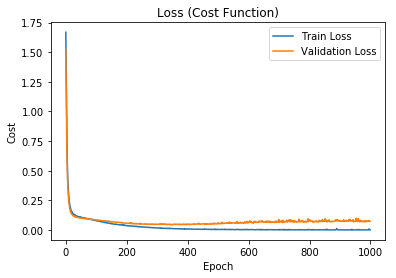

In [9]:
#Visualize the loss
plt.figure(1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title("Loss (Cost Function)")
plt.legend()
plt.show()

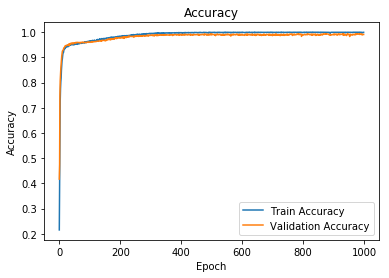

In [10]:
#Visualize the Accuracy
plt.figure(2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Accuracy")
plt.legend()
plt.show()

In [11]:
tf.reset_default_graph()

with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('my_deep_model.ckpt.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    print("Model restored.")
    
    g=tf.get_default_graph()
    X = g.get_tensor_by_name('graph_inputs/input_placeholder:0')
    y = g.get_tensor_by_name('graph_inputs/output_placeholder:0')

    accuracy_update_op = g.get_tensor_by_name('CNN/Accuracy/accuracy/update_op:0')
    accuracy = g.get_tensor_by_name('CNN/Accuracy/accuracy/value:0')

    tf.local_variables_initializer().run()
    _= sess.run([accuracy_update_op], feed_dict={X:xTest, y: yTest})
    accuracy_test = sess.run(accuracy)
    print("Final test accuracy: {:>.2%}".format(accuracy_test)) 

INFO:tensorflow:Restoring parameters from ./my_deep_model.ckpt
Model restored.
Final test accuracy: 94.03%
